In [17]:
import pandas as pd                    # for data handling
import numpy as np                     # for random selections, mainly
import matplotlib.pyplot as plt        # for plotting
from collections import Counter
# %matplotlib inline                  
plt.rcParams['figure.figsize'] = 7,7   # graph dimensions
plt.rcParams['font.size'] = 14         # graph font size
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号

## 0.create datasets of blobs
- 构建blob是数据集，用于测试PU-Learning不同Approaches的效果

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(
    n_samples = 6000, 
    centers = [[1,5], [5,1], [0,0], [6,6]]
)
y = (y>1).astype(int)
X = pd.DataFrame(X, columns=['feature1', 'feature2'])
y = pd.Series(y)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Check the contents of the set
print('%d data points and %d features' % (X.shape))
print('%d positive out of %d total' % (sum(y), len(y)))

6000 data points and 2 features
3000 positive out of 6000 total


### 0.1 plot the original data set
- 绘制原始blobs数据集

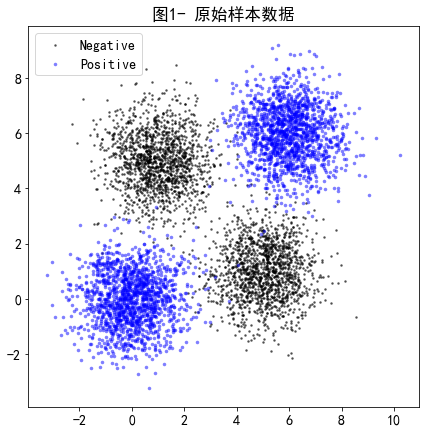

In [4]:
plt.scatter(
    X[y==0].feature1, X[y==0].feature2,
    c='k', marker='.', linewidths=1, s=10, alpha=0.5, 
    label='Negative'
)

plt.scatter(
    X[y==1].feature1, X[y==1].feature2,
    c='b', marker='.', linewidth=0, s=50, alpha=0.5,
    label='Positive'
)
plt.legend()
plt.title('图1- 原始样本数据')
plt.show()

### 0.2 对标记为1的样本取消其样本label 取消数量为hidden_size=2700

In [5]:
y_orig = y.copy()

hidden_size = 2700
y.loc[
    np.random.choice(
        y[y==1].index,
        replace=False,
        size=hidden_size
    )
] = 0

In [6]:
# Check the new contents of the set
print('%d positive out of %d total' % (sum(y), len(y)))

300 positive out of 6000 total


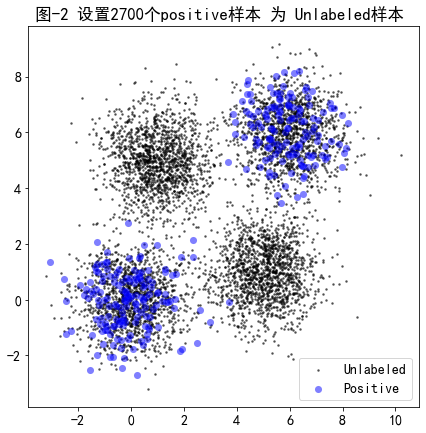

In [7]:
# plot the data set, as model can see it
plt.scatter(
    X[y==0].feature1, X[y==0].feature2,
    c='k', marker='.', linewidths=1, s=10, alpha=0.5, 
    label='Unlabeled'
)

plt.scatter(
    X[y==1].feature1, X[y==1].feature2,
    c='b', marker='o', linewidth=0, s=50, alpha=0.5,
    label='Positive'
)
plt.legend()
plt.title('图-2 设置2700个positive样本 为 Unlabeled样本 ')
plt.show()

## PU-Learning Approaches 对比
### 1.1 standard classifier
- 标准分类器

In [8]:
from sklearn.ensemble import RandomForestClassifier

# 使用标准分类器对Blobs样本进行分类
forest = RandomForestClassifier(
    n_estimators=100, 
    n_jobs=-1
)

# X 为Blobs的特征数据（共两维）
# y 为Blob数据的标签（已设置2700 positive样本数据集为 unlabeled数据）
forest.fit(X, y)

results = pd.DataFrame(
{
    'truth': y_orig,
    'label': y,
    'output_std': forest.predict_proba(X)[:, 1]
}, columns=['truth', 'label', 'output_std']
)

### 1.2  conclusion of standard classifier 
- 展示`lable==0` 即`unlabeled`的全部数据，查看经过`standard classifier`发现的`positive`的样本

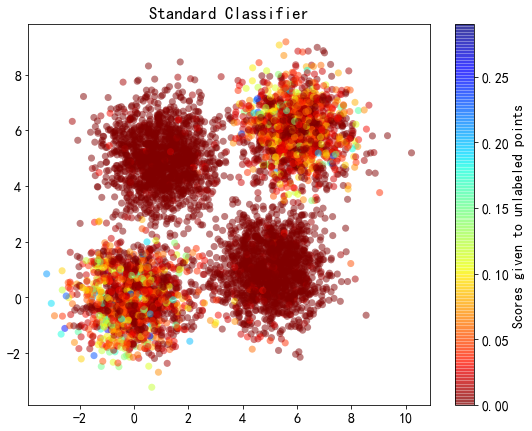

In [9]:
plt.rcParams['figure.figsize'] = 9, 7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2,
    c = results[y==0].output_std, linewidth=0, s=50, alpha=0.5, cmap='jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard Classifier')
plt.show()

## 2.1 Bagging
- Bagging方法

In [10]:
from sklearn.tree import DecisionTreeClassifier
n_estimators = 1000
estimator = DecisionTreeClassifier()

# iP表示为positive样本的index
iP = y[y>0].index

# iU表示为 unlabeled样本的index
iU = y[y<=0].index

# 对于每次的数据迭代，记录数据被OOB的次数
num_oob = pd.DataFrame(np.zeros(shape=y.shape), index=y.index)

# 记录每一轮 OOB data的score
sum_oob = pd.DataFrame(np.zeros(shape=y.shape), index=y.index)

for _ in range(n_estimators):
    if _%100 == 0:
        print("当前迭代次数为：%d" %(_))
    
    # Bootstrap 抽取数据  每次抽样unlabeled样本数量与positive样本数量比为1：1
    # iB 表示 bagging data的index
    iB = np.random.choice(iU, replace=True, size=len(iP))
    
    # out of bag样本的index i_oob（unlabeled samples）
    i_oob = list(set(iU) - set(iB))
    
    # 组合 positive样本集 + unlabeled样本集
    Xb= X[y>0].append(X.loc[iB])
    yb = y[y>0].append(y.loc[iB])
    
    # 训练分类器模型
    estimator.fit(Xb, yb)
    
    # 迭代过程中循环更新 oob数据的 sum_oob 以及 num_oob
    sum_oob.loc[i_oob, 0] += estimator.predict_proba(X.loc[i_oob])[:, 1]
    num_oob.loc[i_oob, 0] += 1

# 取sum_oob / num_oob 数据值作为 Bagging方法 对unlabeled数据的learning 结果
results['output_bag'] = sum_oob / num_oob

当前迭代次数为：0
当前迭代次数为：100
当前迭代次数为：200
当前迭代次数为：300
当前迭代次数为：400
当前迭代次数为：500
当前迭代次数为：600
当前迭代次数为：700
当前迭代次数为：800
当前迭代次数为：900


## 2.2 conclusion
- PU-Learning bagging的数据 可视化展示`label=0`即 `unlabeled` 的数据

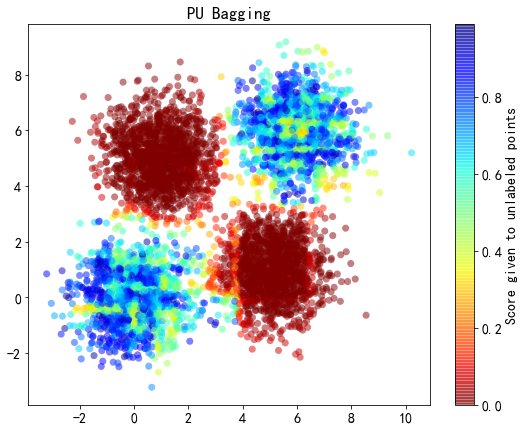

In [11]:
# 展示unlabeled数据集 在经过Bagging方法后的效果
plt.scatter(
    X[y==0].feature1, X[y==0].feature2,
    c=results[y==0].output_bag, linewidth=0, s=50, alpha=0.5, cmap='jet_r'
)
plt.colorbar(label='Score given to unlabeled points')
plt.title('PU Bagging')
plt.show()

## 3.1 Using `BaggingClassifierPU`

In [12]:
from baggingPU import BaggingClassifierPU
bc = BaggingClassifierPU(
    DecisionTreeClassifier(),
    n_estimators = 1000,
    max_samples = sum(y),
    n_jobs = -1
)
bc.fit(X, y)
results['output_skb'] = bc.oob_decision_function_[:, 1]

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


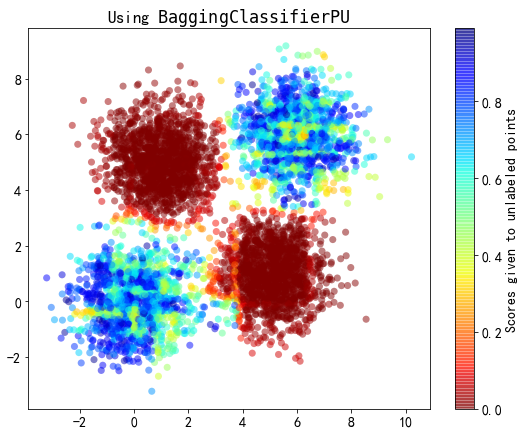

In [13]:
# Visualize the approach's result
plt.scatter(
    X[y==0].feature1, X[y==0].feature2,
    c=results[y==0].output_skb, linewidth=0, s=50, alpha=0.5, cmap='jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt BaggingClassifierPU}$')
plt.show()

## 4. Using `Two-Step`
### 4.1 Step1 + Step2
- Step1 识别可靠负样本集 RN `Reliable Negative`
> 如果未标注数据 得到score超过全部已知的positive样本数据的score值，则label为positive
> 或者score低于全部已知的positive的score值 ，则label为negative
- Step2 利用 `Positive Samples` 和 `RN`集合组成训练集，训练传统的二分类模型

In [18]:
Counter(y)

Counter({0: 5700, 1: 300})

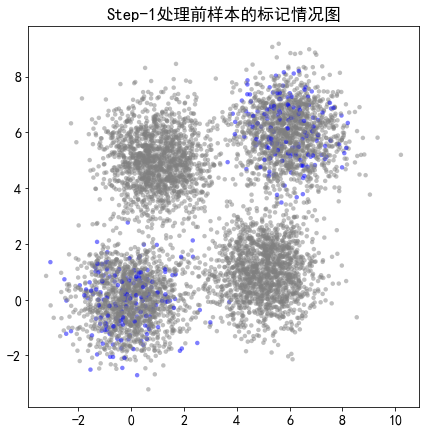

In [19]:
ys = 2 * y -1
# Step-1处理前样本
cdict = {-1: 'gray', 0: 'darkred', 1: 'blue'}
plt.scatter(
    X.feature1, X.feature2,
    c = [cdict[k] for k in ys],
    linewidths=0, s=20, alpha=0.5
)

plt.title('Step-1处理前样本的标记情况图')
plt.show()

In [20]:
print("输出Step-1处理之前的样本标注情况")
Counter(ys)

输出Step-1处理之前的样本标注情况


Counter({-1: 5700, 1: 300})

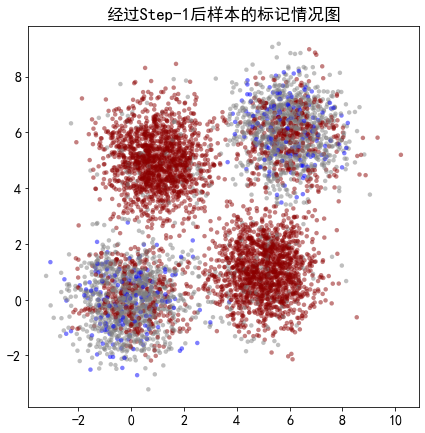

In [28]:
# 对label进行调整 
# `1` 表示为`positive`;
# `-1` 表示为`unlabeled `;
# `0` 表示为实锤`negative`;

ys = 2 * y -1

# 根据普遍意义的随机森林预测样本数据
pred = forest.predict_proba(X)[:,1]

# 根据预测结果 判断 positive 数据的概率范围
range_P = [min(pred * (ys>0)), max(pred * (ys>0))]


# STEP 1
# 如果未标注数据 得到score超过全部已知的positive样本数据的score值，则label为postive
# 或者score低于全部已知的positive的score值 ，则label为negative

# 新的positive样本
iP_new = ys[(ys<0) & (pred >= range_P[1])].index

# 新的negative样本
iN_new = ys[(ys<0) & (pred <= range_P[0])].index

# 实锤unlabeled样本数据的标签
ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

# STEP1通过散点图查看标注的效果
plt.rcParams['figure.figsize'] = 7,7

plt.scatter(
    X.feature1, X.feature2,
    c = [cdict[k] for k in ys],
    linewidths=0, s=20, alpha=0.5
)

plt.title('经过Step-1后样本的标记情况图')
plt.show()


In [29]:
print("输出Step-1处理之后的样本标注情况")
Counter(ys)

输出Step-1处理之后的样本标注情况


Counter({0: 3557, -1: 2143, 1: 300})

In [30]:
# Classifier to be used for step 2
rf2 = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)

# Limit to 10 iterations (this is arbitrary, but 
# otherwise this approach can take a very long time)
# 随机设置超参数迭代次数为10次
for i in range(10):
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        break
    
    print('Step 1 labeled %d new positives and %d new negatives.' %(len(iP_new), len(iN_new)))
    print('正在执行Step2，当前迭代次数为%d次' %(i+1), end=' ')
    
    # STEP 2
    # Retrain on new labels and get new scores
    print(Counter(ys))
    
    rf2.fit(X)
#     rf2.fit(X, ys)
    print("当前预测的结果为：",rf2.predict_proba(X))
    pred = rf2.predict_proba(X)[:,-1]
    
    # Find the range of scores given to positive data points
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
    
    # Repeat step 1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0
    
    
# Lastly, get the scores assigned by this approach    
results['output_stp'] = pred

Step 1 labeled 0 new positives and 3557 new negatives.
正在执行Step2，当前迭代次数为1次 Counter({0: 3557, -1: 2143, 1: 300})
当前预测的结果为： [[0.175 0.772 0.053]
 [0.012 0.988 0.   ]
 [0.945 0.049 0.006]
 ...
 [0.215 0.78  0.005]
 [0.    1.    0.   ]
 [0.312 0.682 0.006]]
Step 1 labeled 0 new positives and 98 new negatives.
正在执行Step2，当前迭代次数为2次 Counter({0: 3655, -1: 2045, 1: 300})
当前预测的结果为： [[0.194 0.758 0.048]
 [0.016 0.984 0.   ]
 [0.954 0.037 0.009]
 ...
 [0.235 0.764 0.001]
 [0.001 0.999 0.   ]
 [0.308 0.685 0.007]]
Step 1 labeled 0 new positives and 43 new negatives.
正在执行Step2，当前迭代次数为3次 Counter({0: 3698, -1: 2002, 1: 300})
当前预测的结果为： [[0.177 0.77  0.053]
 [0.    1.    0.   ]
 [0.95  0.044 0.006]
 ...
 [0.222 0.777 0.001]
 [0.001 0.999 0.   ]
 [0.338 0.659 0.003]]
Step 1 labeled 0 new positives and 15 new negatives.
正在执行Step2，当前迭代次数为4次 Counter({0: 3713, -1: 1987, 1: 300})
当前预测的结果为： [[0.179 0.771 0.05 ]
 [0.002 0.998 0.   ]
 [0.95  0.047 0.003]
 ...
 [0.211 0.788 0.001]
 [0.    1.    0.   ]
 [0.336 0.65

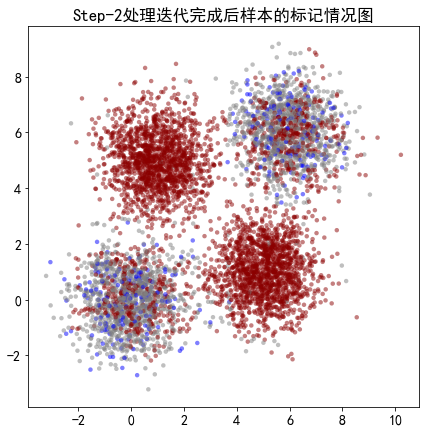

In [25]:
from collections import Counter
Counter(ys)
plt.scatter(
    X.feature1, X.feature2,
    c = [cdict[k] for k in ys],
    linewidths=0, s=20, alpha=0.5
)

plt.title('Step-2处理迭代完成后样本的标记情况图')
plt.show()

In [26]:
print("输出Step-2处理之后的样本标注情况")
Counter(ys)

输出Step-2处理之后的样本标注情况


Counter({0: 3748, -1: 1952, 1: 300})

### 4.2 对Two-Step方法的效果可视化展示

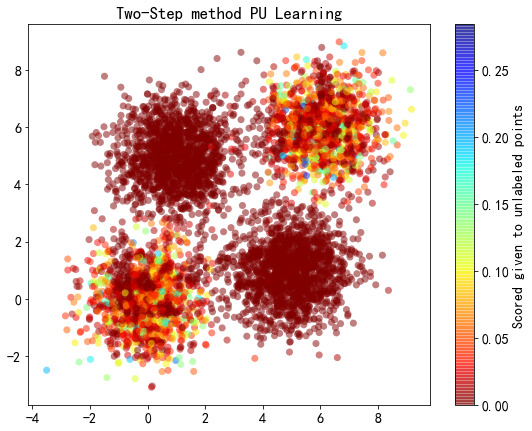

In [32]:
# Visualize this approach's final results
plt.rcParams['figure.figsize']=9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2,
    c=results[y==0].output_stp, linewidths=0, s=50, alpha=0.5, cmap='jet_r'
)
plt.colorbar(label='Scored given to unlabeled points')
plt.title('Two-Step method PU Learning')
plt.show()

## 5. 方法比较

In [35]:
# 对于每一个数据，计算3种方法的平均值
results['output_all'] = results[['output_std', 'output_bag', 'output_stp']].mean(axis=1)

#### 5.1 可视化三种不同方法的平均效果

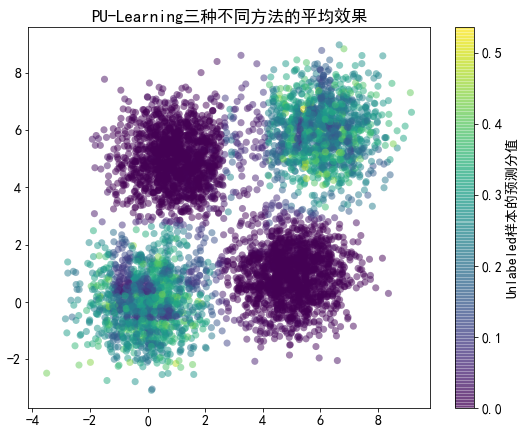

In [36]:
plt.rcParams['figure.figsize'] = 9, 7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, c=results[y==0].output_all, linewidths=0, s=50, alpha=0.5
)
plt.colorbar(label='Unlabeled样本的预测分值')
plt.title('PU-Learning三种不同方法的平均效果')
plt.show()

#### 5.2 对于三种不同的PU-Learning的表现可视化展示
- 成功识别隐藏positive样本的数量

In [70]:
# 打印经过output_std learning 方法后，排名前1000的unlabeled（实质为positive样本）数据的真实label标签
sum(results[results.label==0].sort_values('output_all', ascending=False).head(1000).truth)

1187

In [57]:
# 将全部hidden_size 按照步长为100设置不同的数量级
ts = range(100, hidden_size, 100)
y_std, y_bag, y_skb, y_stp, y_all = [], [], [], [], []

for t in ts:
    # 针对不同的PU-Learning的方法添加  
    # 对未标注数据的识别的positive分数最高的TOP(100,200,300,....3000) 真正positive样本的平均值
    
    # 方法一: standard classifier
    y_std.append(
        results[results.label==0].sort_values(
            'output_std', ascending=False
        ).head(t).truth.mean()
    )
    # 方法二: Bagging
    y_bag.append(
        results[results.label==0].sort_values(
            'output_bag', ascending=False
        ).head(t).truth.mean()
    )
    # 方法三：BaggingClassifierPU
    y_skb.append(
        results[results.label==0].sort_values(
            'output_skb', ascending=False
        ).head(t).truth.mean()
    )
    # 方法四：TWO-STEP
    y_stp.append(
        results[results.label==0].sort_values(
            'output_stp', ascending=False
        ).head(t).truth.mean()
    )
    # 方法五：方法一、二、四比较的平均值
    y_all.append(
        results[results.label==0].sort_values(
            'output_all', ascending=False
        ).head(t).truth.mean()
    )

In [20]:
# 比较PU-Bagging和BaggingClassifierPU 的区别
[y_bag[i] - y_skb[i] for i in range(len(y_bag))]

[0.0,
 0.0,
 -0.0033333333333334103,
 0.0,
 0.0,
 0.0,
 -0.0014285714285713347,
 0.0,
 -0.0011111111111110628,
 0.0,
 0.0,
 -0.0008333333333333526,
 -0.0007692307692307443,
 0.0,
 0.0,
 0.0,
 -0.0005882352941175562,
 -0.0005555555555556424,
 0.0,
 0.000500000000000056,
 0.0,
 0.0,
 -0.00043478260869567187,
 0.0,
 0.0,
 0.0]

- 四种不同的PU-learning的处理方法展示
-- Performance graphing

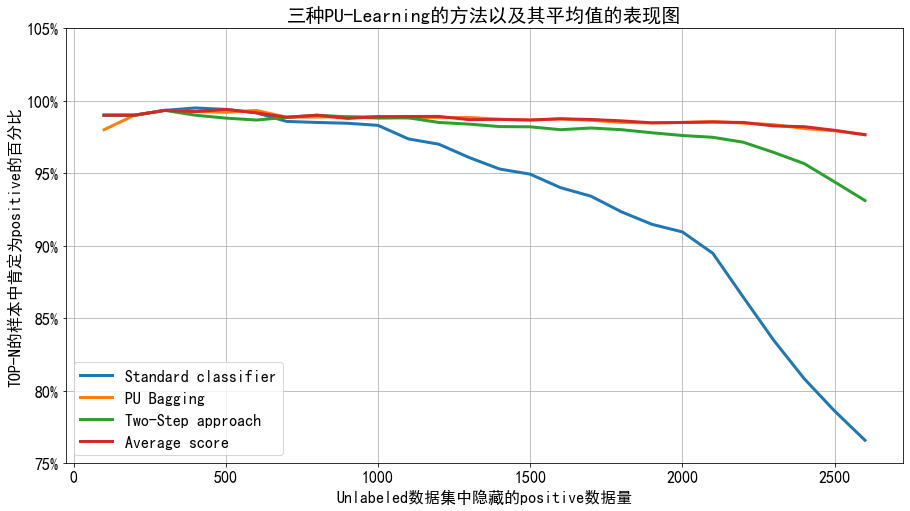

In [71]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8

plt.plot(
    ts, y_std,
    ts, y_bag,
    ts, y_stp,
    ts, y_all,
    lw=3
)
vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' %(v*100) for v in vals])
plt.xlabel('Unlabeled数据集中隐藏的positive数据量')
plt.ylabel('TOP-N的样本中肯定为positive的百分比')
plt.legend([
    'Standard classifier',
    'PU Bagging',
    'Two-Step approach',
    'Average score'
])

ylim = plt.gca().get_ylim()
plt.title('三种PU-Learning的方法以及其平均值的表现图')
plt.grid()
plt.show()

## 综上从数据集上来看，Bagging表现最好！！！！